In [1]:
import torch
import pandas as pd

from rlportfolio.environment import PortfolioOptimizationEnv
from rlportfolio.algorithm import PolicyGradient, EpisodicPolicyGradient
from rlportfolio.policy import EI3

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

TOP_NASDAQ = [
    "AAPL", "MU", "CSCO", "MSFT", "META", "QQQ",
    "CMCSA", "INTC", "HBAN", "NVDA"
]

bovespa_temporal = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
bovespa_temporal

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.281910,576145,ABEV3.SA,0
1,2011-01-03,15.750000,15.900000,15.690000,6.244403,6626800,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.287279,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.243609,10014663,ITUB4.SA,0
4,2011-01-03,8.422694,8.629907,8.422694,6.163040,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,24.990000,25.049999,24.430000,16.668444,57901800,PETR4.SA,3
29776,2022-12-29,37.250000,37.480000,36.619999,37.150330,7890300,PRIO3.SA,3
29777,2022-12-29,54.300869,55.776001,52.626392,50.846733,8786791,RENT3.SA,3
29778,2022-12-29,89.000000,89.949997,88.830002,77.194092,40110800,VALE3.SA,3


In [3]:
from rlportfolio.data import GroupByScaler

df_portfolio = bovespa_temporal[["date", "tic", "close", "high", "low"]]

df_portfolio = GroupByScaler(columns = ["close", "high", "low"], by="tic").fit_transform(df_portfolio)

df_portfolio

,date,tic,close,high,low
0,2011-01-03,ABEV3.SA,0.272899,0.355383,0.359147
1,2011-01-03,BBAS3.SA,0.320274,0.568771,0.572419
2,2011-01-03,BBDC4.SA,0.281505,0.397479,0.399922
3,2011-01-03,ITUB4.SA,0.328329,0.458661,0.467793
4,2011-01-03,LREN3.SA,0.126038,0.157120,0.155466
...,...,...,...,...,...
29775,2022-12-29,PETR4.SA,0.694899,0.652514,0.662958
29776,2022-12-29,PRIO3.SA,0.857373,0.844144,0.878173
29777,2022-12-29,RENT3.SA,0.728877,0.754746,0.727218
29778,2022-12-29,VALE3.SA,0.916710,0.746783,0.770759


In [4]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2019-10-16") & (df_portfolio["date"] < "2020-12-31")]

environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        state_normalization="by_last_close",
        comission_fee_pct=0.0025,
        time_window=50,
        time_format="%Y-%m-%d",
        features=["close", "high", "low"],
        print_metrics=False,
        plot_graphs=False,
        # comission_fee_model="trf_approx"
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        state_normalization="by_last_close",
        comission_fee_pct=0.0025,
        time_window=50,
        time_format="%Y-%m-%d",
        features=["close", "high", "low"],
        print_metrics=False,
        plot_graphs=True,
    )

In [5]:
len(df_portfolio_train["date"].unique())

2233

In [6]:
algo = EpisodicPolicyGradient(
    environment_train,
    # policy=EI3,
    sample_bias=0.001,
    batch_size=200,
    lr=5e-5,
    action_noise="dirichlet",
    action_epsilon=0.05,
    action_alpha=1.0,
    use_tensorboard=True,
    device=device
)

In [7]:
algo.train(episodes=120, val_period=10, val_gradient_steps=30, val_env=environment_test)

Completed: 100%|██████████| 120/120 [53:09<00:00, 26.58s/episode, fapv=245, mdd=-0.651, sharpe=0.0824, val_fapv=1.62, val_mdd=-0.724, val_sharpe=0.0631]         


({'value': 24495956.0,
  'fapv': 244.95956,
  'mdd': -0.6508854202450509,
  'sharpe': 0.08236567579846805},
 {'value': 161663.53,
  'fapv': 1.6166353125,
  'mdd': -0.7242202554968243,
  'sharpe': 0.06308508696564828})

In [9]:
torch.save(algo.train_policy.state_dict(), "policy_BR.pt")

In [8]:
eiie_values = environment_test._asset_memory["final"]
eiie_values

[100000,
 101468.67,
 100642.38,
 101832.234,
 101435.6,
 100807.625,
 100477.12,
 100047.445,
 100245.734,
 99155.05,
 97667.71,
 97568.58,
 98659.27,
 99155.055,
 97899.086,
 96808.38,
 97998.22,
 96841.445,
 92643.875,
 95188.86,
 95354.125,
 95651.58,
 94032.03,
 93139.66,
 94626.98,
 93833.74,
 96444.82,
 95618.53,
 96279.56,
 97436.43,
 99584.805,
 98229.695,
 97238.13,
 97039.805,
 98328.84,
 100972.984,
 98890.73,
 96312.68,
 86628.52,
 83620.945,
 83753.1,
 87686.234,
 86099.77,
 88876.12,
 83587.84,
 75457.15,
 53048.055,
 58038.88,
 52387.03,
 41645.22,
 50899.69,
 42059.367,
 39859.25,
 28083.268,
 32099.037,
 33645.656,
 32234.707,
 35463.605,
 46913.977,
 50226.125,
 46245.117,
 46522.453,
 45473.293,
 44874.246,
 53097.562,
 56712.21,
 67782.79,
 70737.125,
 77129.28,
 74563.164,
 75039.98,
 74153.5,
 72602.195,
 69676.45,
 71493.44,
 70695.64,
 74241.49,
 75127.945,
 70695.64,
 72911.73,
 76478.66,
 80689.32,
 80024.305,
 77053.87,
 79536.64,
 76610.55,
 77319.46,
 8074

In [9]:
# uniform buy and hold
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0] + [1/10] * 10))

In [10]:
ubah_values = environment_test._asset_memory["final"]
ubah_values

[100000,
 102891.766,
 102706.75,
 102439.46,
 102186.9,
 101077.78,
 99700.75,
 99461.04,
 101126.71,
 101663.47,
 100852.93,
 101446.17,
 102846.97,
 103442.445,
 102269.84,
 103559.19,
 105267.57,
 104762.46,
 102350.2,
 104330.73,
 103423.11,
 103735.17,
 101797.81,
 102374.67,
 102904.836,
 103642.72,
 103108.516,
 102641.57,
 101285.445,
 104021.8,
 104821.1,
 103929.71,
 103067.234,
 103428.836,
 103438.92,
 104871.16,
 103935.84,
 103510.19,
 95933.56,
 93313.195,
 94166.35,
 96847.84,
 96062.53,
 97853.62,
 93874.55,
 89599.52,
 76904.84,
 82261.9,
 75926.77,
 63928.094,
 72800.15,
 61185.17,
 63316.14,
 55240.9,
 57872.906,
 57875.41,
 54536.25,
 60022.395,
 67124.03,
 69791.35,
 65491.125,
 65284.527,
 63589.75,
 61439.383,
 64216.707,
 61904.37,
 67875.62,
 71405.02,
 73835.625,
 71408.21,
 71762.79,
 72010.16,
 70552.125,
 68911.914,
 70689.555,
 70201.914,
 71408.555,
 70405.484,
 66524.51,
 68618.59,
 73005.43,
 74310.59,
 71229.18,
 69656.7,
 70475.11,
 69215.54,
 67653

In [11]:
# best performing stock
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [12]:
best_stock_values = environment_test._asset_memory["final"]
best_stock_values

[100000,
 101419.22,
 100124.15,
 100383.13,
 101160.17,
 97332.52,
 95893.5,
 97850.53,
 98771.51,
 100728.51,
 101390.414,
 103232.33,
 105908.79,
 109160.93,
 107894.65,
 111952.55,
 114111.016,
 119233.77,
 117909.91,
 120902.95,
 121996.61,
 117909.91,
 113420.28,
 117046.47,
 116614.836,
 119061.08,
 123291.67,
 118284.04,
 119521.53,
 123896.06,
 128241.76,
 131148.5,
 131148.5,
 131752.89,
 128644.66,
 140501.83,
 136674.19,
 143322.28,
 135230.27,
 126971.484,
 124603.61,
 135692.31,
 138377.81,
 139937.22,
 134854.88,
 127115.875,
 114785.47,
 121022.88,
 113197.23,
 95293.61,
 99711.74,
 79151.46,
 82818.805,
 76437.04,
 82963.21,
 93474.36,
 101741.52,
 104227.33,
 107984.78,
 109690.12,
 102204.06,
 98330.88,
 97030.24,
 93735.23,
 98562.14,
 95064.78,
 96192.02,
 107811.39,
 115586.51,
 110701.75,
 113476.52,
 112435.984,
 109834.664,
 109863.52,
 111164.19,
 113014.05,
 118274.53,
 114430.36,
 111886.805,
 117349.625,
 120182.234,
 119661.92,
 115441.96,
 115152.97,
 112

In [13]:
# follow the loser: invest in the worst performing stock in training
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]))

In [14]:
follow_loser_values = environment_test._asset_memory["final"]
follow_loser_values

[100000,
 107956.9,
 114202.59,
 116435.34,
 116586.21,
 114202.586,
 109827.586,
 112301.72,
 117129.31,
 124038.8,
 124612.07,
 124853.445,
 123737.055,
 129922.414,
 134931.03,
 139396.55,
 140392.25,
 137284.5,
 135112.08,
 143620.7,
 138068.98,
 142715.52,
 144616.38,
 144737.06,
 147241.38,
 144827.58,
 144495.69,
 145762.9,
 131702.58,
 137254.3,
 136228.44,
 135323.28,
 137284.48,
 135775.86,
 141659.48,
 141961.19,
 144767.22,
 144706.89,
 123405.164,
 120086.2,
 118879.305,
 127629.31,
 126060.33,
 124702.58,
 119331.89,
 106931.03,
 67857.76,
 77030.17,
 70331.9,
 47340.52,
 56331.9,
 46767.24,
 44323.273,
 31228.445,
 35693.96,
 37413.793,
 35844.824,
 39435.34,
 52168.094,
 57116.37,
 54612.06,
 51293.098,
 50387.92,
 49724.13,
 58836.2,
 62849.13,
 77603.44,
 82974.125,
 84452.58,
 74525.86,
 70784.48,
 71478.44,
 70905.164,
 67887.92,
 66409.48,
 62155.164,
 59771.547,
 60193.957,
 55969.82,
 56573.266,
 65745.67,
 64900.844,
 61702.57,
 59530.156,
 63905.15,
 62728.43,


In [15]:
# follow the winner: invest in the best performing stock in training set
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [16]:
follow_winner_values = environment_test._asset_memory["final"]
follow_winner_values

[100000,
 102075.55,
 101365.484,
 101276.72,
 101223.46,
 101880.29,
 101099.19,
 101418.72,
 103620.0,
 102306.32,
 101631.766,
 102448.36,
 105128.94,
 105626.02,
 104649.65,
 106247.35,
 108058.086,
 106815.45,
 104525.4,
 105927.81,
 106513.64,
 105093.46,
 101986.83,
 102572.625,
 101010.445,
 101543.0,
 98028.04,
 98649.39,
 97566.5,
 100282.59,
 100566.625,
 101738.27,
 100211.586,
 101543.01,
 100921.71,
 100318.1,
 98578.375,
 99412.74,
 93465.73,
 90625.35,
 94619.63,
 94087.055,
 94672.89,
 96838.664,
 91956.766,
 90146.05,
 81660.47,
 89205.195,
 83595.47,
 76707.59,
 83045.15,
 65505.9,
 68417.27,
 56807.28,
 65328.38,
 61208.06,
 53363.613,
 58682.195,
 65459.363,
 68821.28,
 64036.324,
 63484.906,
 59696.09,
 57365.883,
 57170.215,
 55071.254,
 61812.844,
 65815.12,
 67149.19,
 65068.008,
 64107.47,
 64143.06,
 63591.625,
 63413.754,
 66704.5,
 69372.69,
 72805.76,
 70173.16,
 67006.91,
 68767.91,
 71542.805,
 72165.39,
 68320.99,
 66221.0,
 64690.496,
 63409.13,
 59280

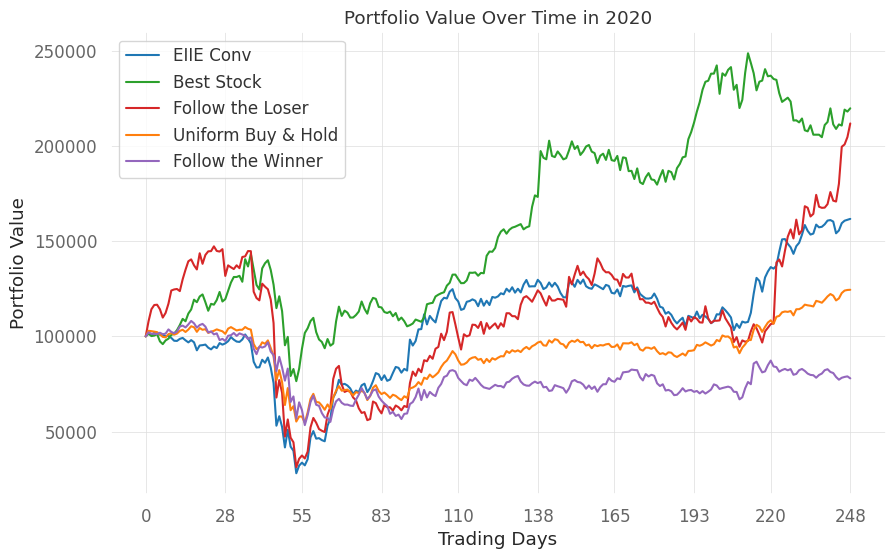

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(eiie_values, "tab:blue", label="EIIE Conv")
plt.plot(best_stock_values, "tab:green", label="Best Stock")
plt.plot(follow_loser_values, "tab:red", label="Follow the Loser")
plt.plot(ubah_values, "tab:orange", label="Uniform Buy & Hold")
plt.plot(follow_winner_values, "tab:purple", label="Follow the Winner")
plt.title("Portfolio Value Over Time in 2020")
plt.legend()
plt.xticks(
    np.round(np.linspace(0, len(eiie_values) - 1, 10))
)
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.show()
plt.savefig("comparison.png", bbox_inches="tight")
plt.close()